# Module 3.1: Construct Dynamic Circuits

**IBM Qiskit v2.x Study Guide — Task 3.1**  
*Classical feedforward and control flow: `if_test`, `for_loop`,  
`while_loop`, `if_else`*

> This notebook targets Qiskit v2.x APIs and dynamic circuit features.  
> It uses `FakeTorino` for local testing.  
> All execution examples transpile using a **preset PassManager** before  
> calling `run()`.


In [1]:
# 3.1.0 — Title & Metadata
# Metadata: versions and imports
import sys, platform
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

print(f'Python: {platform.python_version()} on {platform.system()}')
print(f'Qiskit: {qiskit.__version__}')
import qiskit_ibm_runtime as qir
print(f"qiskit-ibm-runtime: {qir.__version__}")

# Create a fake backend once and reuse
backend = FakeTorino()
backend


Python: 3.12.9 on Darwin
Qiskit: 2.2.1
qiskit-ibm-runtime: 0.41.1


## 3.1.1 — Conceptual Overview

Dynamic circuits enable **classical feedback** within a quantum program.  
Measurements performed mid-circuit can drive **control flow** such as  
`if`-branches and loops. In Qiskit v2.x these are exposed as circuit-level  
constructs:

- `with qc.if_test((c, v)):` guarded block that executes if the classical bit  
  or register `c` equals value `v`.  
- `qc.if_else(...)` builds a branch from separate subcircuits.  
- `with qc.for_loop(iterable):` repeats a body for each item in an iterable.  
- `with qc.while_loop((c, v)):` repeats a body while `(c == v)` holds.  

Let $c$ denote a classical bit or register and $v$ an integer value.  
The predicate is evaluated **at run time** using previously measured outcomes.  
Dynamic circuits require hardware or simulators that support mid-circuit  
measurement and conditional execution.  


## 3.1.2 — Hands-on Examples and Backend-aware Transpilation

We build each example as a small circuit, then transpile it for `FakeTorino`  
via `generate_preset_pass_manager(backend=...)`. This yields a backend-aware  
layout and routing using a preset pipeline. We then run with `SamplerV2`.  
We fix shots for quick execution and reproducible results.  


In [2]:
# Helper to transpile (via preset PassManager) and run a circuit with SamplerV2
def sample_counts_with_pm(qc, shots=512, opt_level=1):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=opt_level)
    tqc = pm.run(qc)
    sampler = SamplerV2(mode=backend)
    job = sampler.run([tqc], shots=shots)
    pub = job.result()[0]
    counts = pub.join_data().get_counts()
    return counts, tqc


### 3.1.3 — Sub-module A: `if_test`

**Docs:**  
- IBM Docs — Classical feedforward and control flow  
  https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

**Idea:** Measure $q_0$ and, if the result is `1`, apply `X` to $q_1$; else do  
nothing. Finally measure $q_1$.  


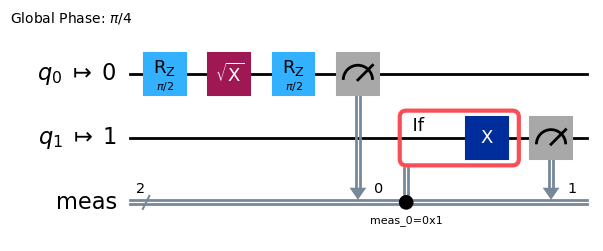

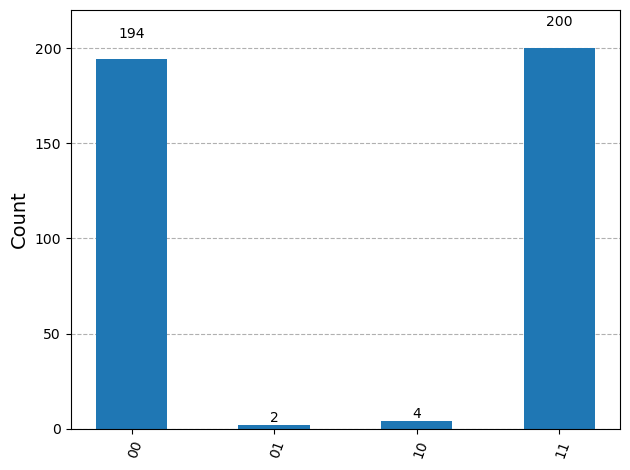

{'00': 194, '11': 200, '01': 2, '10': 4}

In [3]:
# A) if_test example
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'meas')
qc = QuantumCircuit(q, c, name='if_test_demo')

qc.h(q[0])                 # put q0 in superposition
qc.measure(q[0], c[0])     # mid-circuit measure to meas[0]

with qc.if_test((c[0], 1)):
    qc.x(q[1])             # execute only when meas[0] == 1

qc.measure(q[1], c[1])

counts, tqc = sample_counts_with_pm(qc, shots=400)
display(tqc.draw(output='mpl'))
display(plot_histogram(counts))
counts


### 3.1.4 — Sub-module B: `for_loop`

**Docs:**  
- IBM Docs — Classical feedforward and control flow  
  https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

**Idea:** Apply a small rotation to $q_0$ three times using a `for_loop`.  
Then measure.  


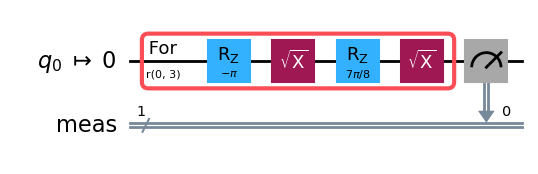

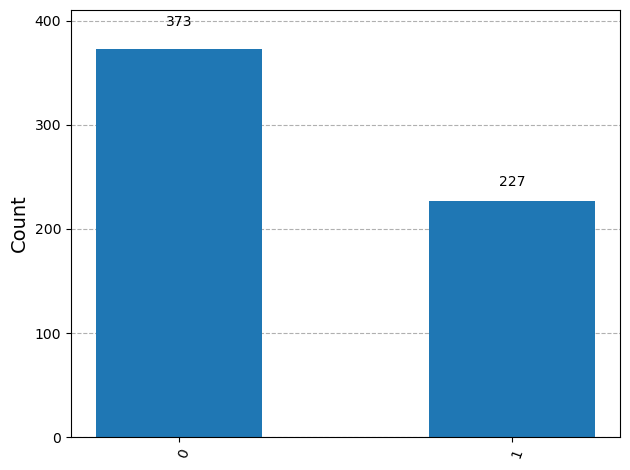

{'1': 227, '0': 373}

In [4]:
# B) for_loop example
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'meas')
qc = QuantumCircuit(q, c, name='for_loop_demo')

import numpy as np
theta = np.pi/8

with qc.for_loop(range(3)):
    qc.ry(theta, q[0])

qc.measure(q[0], c[0])

counts, tqc = sample_counts_with_pm(qc, shots=600)
display(tqc.draw(output='mpl'))
display(plot_histogram(counts))
counts


### 3.1.5 — Sub-module C: `while_loop`

**Docs:**  
- IBM Docs — Classical feedforward and control flow  
  https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

**Idea:** Start in $|0\rangle$, measure into `meas[0]` (so it is `0`), then  
enter a `while_loop` guarded on `(meas[0] == 0)`. The body flips the qubit and  
re-measures, so the loop executes exactly **once**, then exits when the bit  
becomes `1`. Finally, we record a terminal measurement as well.  


In [5]:
# C) while_loop example
q = QuantumRegister(1, 'q')
c = ClassicalRegister(1, 'meas')
qc = QuantumCircuit(q, c, name='while_loop_demo')

qc.reset(q[0])
qc.measure(q[0], c[0])  # meas[0] == 0 with certainty

with qc.while_loop((c[0], 0)):
    qc.x(q[0])
    qc.measure(q[0], c[0])

# Final measurement (often helpful for inspection)
qc.measure(q[0], c[0])

counts, tqc = sample_counts_with_pm(qc, shots=400)
display(tqc.draw(output='mpl'))
display(plot_histogram(counts))
counts


TranspilerError: "The control-flow construct 'while_loop' is not supported by the backend."

### 3.1.6 — Sub-module D: `if_else`

**Docs:**  
- IBM Docs — Classical feedforward and control flow  
  https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

**Idea:** Use the functional `if_else` form with explicit true/false bodies.  
Prepare $q_0$ in $|1\rangle$, measure to `meas[0]`, then branch to set $q_1$.  


In [ ]:
# D) if_else functional example
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'meas')
qc = QuantumCircuit(q, c, name='if_else_demo')

# Prepare control bit deterministically to 1
qc.x(q[0])
qc.measure(q[0], c[0])

# Build the two branches as subcircuits
true_body = QuantumCircuit(q, c, name='true_branch')
true_body.x(q[1])

false_body = QuantumCircuit(q, c, name='false_branch')
false_body.h(q[1])

qc.if_else((c[0], 1), true_body, false_body)
qc.measure(q[1], c[1])

counts, tqc = sample_counts_with_pm(qc, shots=400)
display(tqc.draw(output='mpl'))
display(plot_histogram(counts))
counts


### 3.1.7 — Sub-module E: Multiple Choice Questions

**Q1.** Given the snippet below, what is the most likely histogram outcome?  
```
q = QuantumRegister(1, 'q'); c = ClassicalRegister(1, 'meas')
qc = QuantumCircuit(q, c)
qc.h(q[0]); qc.measure(q[0], c[0])
with qc.if_test((c[0], 1)):
    qc.x(q[0])
qc.measure(q[0], c[0])
```
A) Always `0`  
B) Always `1`  
C) Roughly 50% `0`, 50% `1`  
D) Roughly 25% `0`, 75% `1`  

**Q2.** Which snippet correctly builds a three-iteration loop applying `ry(α)`?  
A)
```
with qc.for_loop(3):
    qc.ry(alpha, 0)
```
B)
```
with qc.for_loop(range(3)):
    qc.ry(alpha, 0)
```
C)
```
qc.for_loop(3, body=None)
```
D)
```
qc.for_loop(range(3), None)
```

**Q3.** In the safe `while_loop` pattern shown above, why does the loop  
terminate?  
A) Because Qiskit limits loop depth to one iteration.  
B) Because the body flips the qubit then re-measures to update the bit.  
C) Because `FakeTorino` forces exit after one iteration.  
D) Because measurements are deferred until the end of the circuit.  

<details>
<summary><b>Answer Key</b></summary>

- Q1: **C**. The first measurement makes the state classical; the branch X  
  toggles the value when the outcome was `1`, yielding an even split overall.  
- Q2: **B**. `for_loop` takes an iterable, e.g., `range(3)`, in the context  
  manager form.  
- Q3: **B**. The body sets the qubit to `|1\rangle` and re-measures, so the  
  predicate `(meas[0] == 0)` becomes false.  
</details>
